In [1]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.preprocessing
import matplotlib.pyplot as plt
import Utils
from Utils import evaluate_model, load_data, validate, train, add_hours

plt.rcParams['figure.figsize'] = [6.4, 4.8] #The default
#plt.rcParams['figure.figsize'] = [20, 10]

path_train = "Data/Train.parquet"
path_val = "Data/Validation.parquet"
path_test= "Data/Test.parquet"
path_trainval = "Data/TrainVal.parquet"

# Decision Trees

Note that trees do not need any data scaling

Baseline of always predicting subscribers:

In [2]:
with warnings.catch_warnings(): #Scikit prints some misleading warnings here
    features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed"]
    baseline = DummyClassifier()
    print("Training: ")
    train(path_train,baseline,features)
    print("Validation: ")
    validate(baseline,path_val,features);

Training: 
Accuracy: 0.8905468036686415
Confusion: 
[[1. 0.]
 [1. 0.]]
MCC: 0.0
Validation: 
Accuracy: 0.8906060229873748
Confusion: 
[[1. 0.]
 [1. 0.]]
MCC: 0.0


We start with a small model.

In [18]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed"]
pre = add_hours
clf = DecisionTreeClassifier(max_depth=6)
print("Training: ")
clf,feature_names = train(path_train,clf,features,preprocess=pre)
print("Validation: ")
validate(clf,path_val,features,preprocess=pre);

Training: 
Accuracy: 0.899347698861101
Confusion: 
[[0.98498342 0.01501658]
 [0.79741238 0.20258762]]
MCC: 0.3162768269893971
Validation: 
Accuracy: 0.8994086394588567
Confusion: 
[[0.98500111 0.01499889]
 [0.79742288 0.20257712]]
MCC: 0.316333970359959


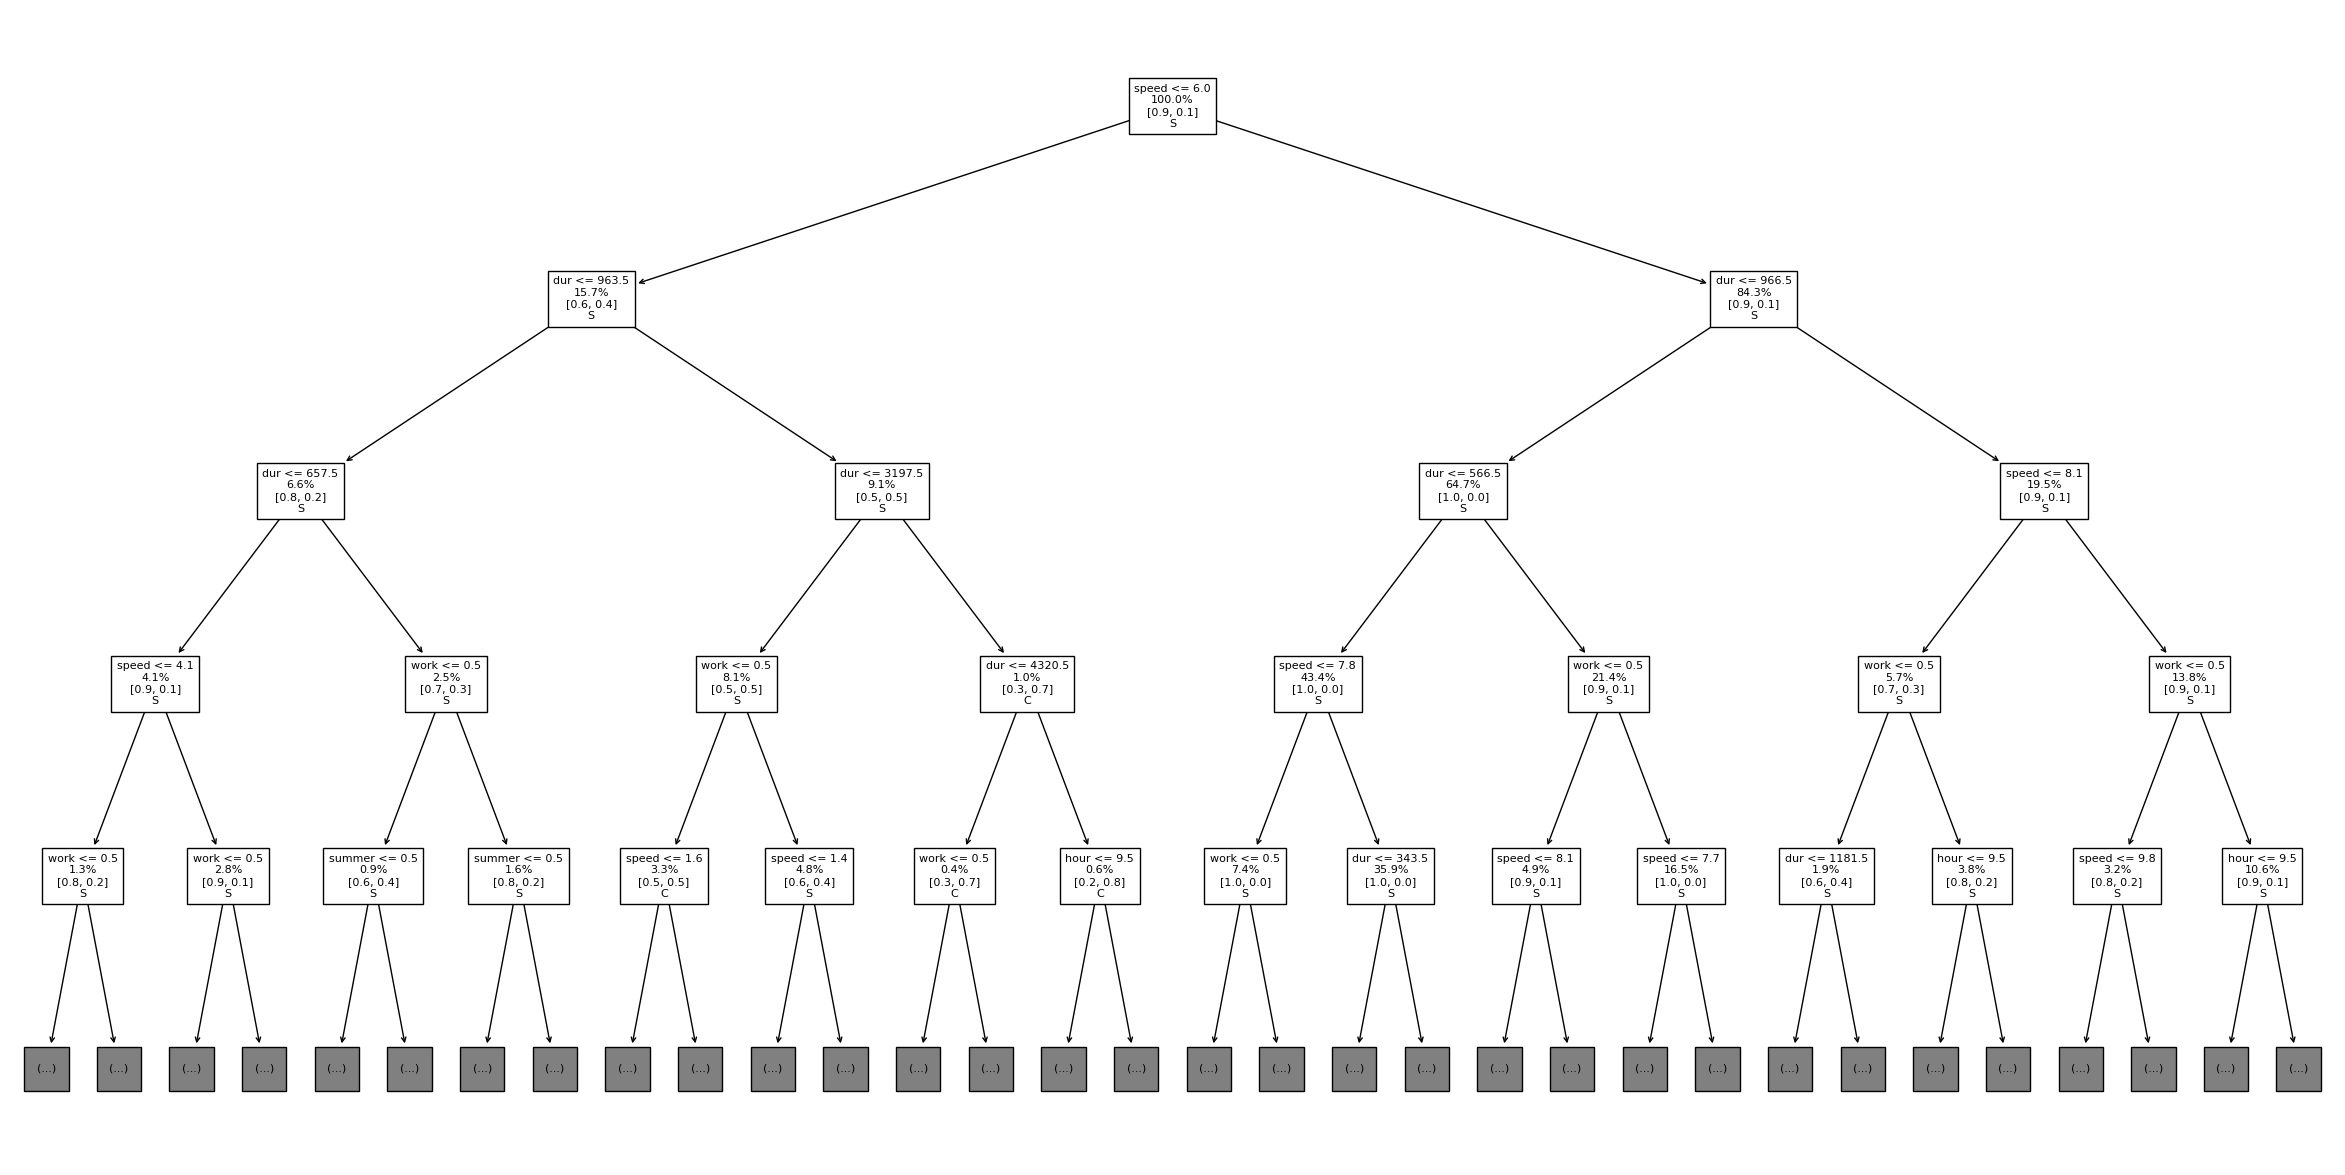

In [32]:
rename = {"tripduration" : "dur", "is_roundtrip":"round", "haversine distance":"dist", "speed":"speed", "business day":"work", "summer":"summer", "hour":"hour"}
feature_names_short = list(map(lambda x: rename[x],feature_names))
plt.figure(figsize=(30,15))
plot_tree(clf,class_names=["S","C"], feature_names=feature_names_short, impurity=False, label=None, fontsize=8, precision=1, proportion=True, max_depth=4);
plt.savefig("Images/ExampleTree.png",dpi=300, bbox_inches="tight")

Since we are not overfitting at all, lets try increasing depth first

In [10]:
clf = DecisionTreeClassifier(max_depth=12)
print("Training: ")
clf,feature_names = train(path_train,clf,features,preprocess=pre)
print("Validation: ")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9039440127139298
Confusion: 
[[0.97900916 0.02099084]
 [0.70681048 0.29318952]]
MCC: 0.38706441552302295
Validation: 
Accuracy: 0.9035167559781075
Confusion: 
[[0.97869066 0.02130934]
 [0.70849436 0.29150564]]
MCC: 0.38382790809615325


In [11]:
clf = DecisionTreeClassifier(max_depth=24)
print("Training: ")
clf,feature_names = train(path_train,clf,features,preprocess=pre)
print("Validation: ")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.928912133496262
Confusion: 
[[0.98210984 0.01789016]
 [0.50392167 0.49607833]]
MCC: 0.5842437470598194
Validation: 
Accuracy: 0.8965259212941854
Confusion: 
[[0.96312265 0.03687735]
 [0.64565607 0.35434393]]
MCC: 0.38432254195614735


At this depth we are starting to outperform the logistic regression, even without using station ids, but also we see that we start overfitting.

Just out of interest, lets see how we perform if we use gender as a feature

In [13]:
features_gender = features + ["gender"]
clf = DecisionTreeClassifier(max_depth=24)
print("Training: ")
clf,feature_names = train(path_train,clf,features_gender,preprocess=preprocess_1)
print("Validation: ")
validate(clf, path_val, features_gender, preprocess=preprocess_1);

Training: 
Accuracy: 0.9622322088507806
Confusion: 
[[0.9937944  0.0062056 ]
 [0.29456807 0.70543193]]
MCC: 0.7924297958617819
Validation: 
Accuracy: 0.9386093730960416
Confusion: 
[[0.98018284 0.01981716]
 [0.39985148 0.60014852]]
MCC: 0.6555033256027879


First we try adding station ids "raw", with no encoding

In [17]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours

In [18]:
clf = DecisionTreeClassifier(max_depth=24)
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation: ")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9470291543955277
Confusion: 
[[0.98715953 0.01284047]
 [0.37948461 0.62051539]]
MCC: 0.7019191263581055
Validation: 
Accuracy: 0.9003171047189278
Confusion: 
[[0.95912273 0.04087727]
 [0.57843542 0.42156458]]
MCC: 0.4318419286884088


(0.9003171047189278,
 array([[0.95912273, 0.04087727],
        [0.57843542, 0.42156458]]))

This notably increases accuracy on customers, but hurts subscribers a tiny bit.

What about frequency encoded stations? -> Does not seem to help, so we stick with raw station ids

In [19]:
def preprocess_1(data,features):
    data,features = add_hours(data,features) # add hours
    data,features = Utils.frequency_encode_stations(data,data)
    return data,features

In [20]:
features=["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed"]
pre=preprocess_1
clf = DecisionTreeClassifier(max_depth=24)
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9497084245802642
Confusion: 
[[0.98861615 0.01138385]
 [0.36685751 0.63314249]]
MCC: 0.7178363759619953
Validation:
Accuracy: 0.897656354136692
Confusion: 
[[0.95800954 0.04199046]
 [0.59369525 0.40630475]]
MCC: 0.4148235875351225


Lets see what happens if we balance classes (and include station)

In [21]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre=add_hours
clf = DecisionTreeClassifier(max_depth = 24,class_weight="balanced")
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.8738295936393738
Confusion: 
[[0.86808033 0.13191967]
 [0.07939255 0.92060745]]
MCC: 0.5961298884341207
Validation:
Accuracy: 0.828571804510633
Confusion: 
[[0.84271851 0.15728149]
 [0.28660032 0.71339968]]
MCC: 0.42033023610070736


This really hurts the overall accuracy (it falls below the baseline of 89%), but significantly improves accuracy on customers. MCC is minimally worse.
We also see that we are overfitting to some extent.

Next, let us start training really deep trees and see what happens.

In [25]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours
clf = DecisionTreeClassifier(class_weight="balanced", max_depth=None)
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9993057796206416
Confusion: 
[[9.99220536e-01 7.79463658e-04]
 [6.53339841e-07 9.99999347e-01]]
MCC: 0.9964550728421022
Validation:
Accuracy: 0.8852278857644981
Confusion: 
[[0.93503201 0.06496799]
 [0.52024098 0.47975902]]
MCC: 0.4132226255558471


This performs slightly worse than the limited max depth. One option is to add pruning, but we can also switch to a random forest.

# Random Forests

Now, lets see if we can also train some random forests

Without class balancing:

In [3]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours
clf = RandomForestClassifier(n_estimators=10, max_depth=24,n_jobs=3)
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9475198569339658
Confusion: 
[[0.99109635 0.00890365]
 [0.40703268 0.59296732]]
MCC: 0.7017209234391517
Validation:
Accuracy: 0.914392023354651
Confusion: 
[[0.97804124 0.02195876]
 [0.60379352 0.39620648]]
MCC: 0.4811527315014177


With class balancing:

In [5]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours
clf = RandomForestClassifier(n_estimators=10, max_depth=24, n_jobs=3, class_weight="balanced")
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9166205426303372
Confusion: 
[[0.92187866 0.07812134]
 [0.12616123 0.87383877]]
MCC: 0.6689432156681953
Validation:
Accuracy: 0.8782753805342439
Confusion: 
[[0.90456018 0.09543982]
 [0.33571627 0.66428373]]
MCC: 0.48721347534378834


To validate the previously discussed assumption that gender will be a strong, but misleading, predictor, we try adding it as a feature.

In [6]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id", "gender"]
pre = add_hours
clf = RandomForestClassifier(n_estimators=10, max_depth=24, n_jobs=3, class_weight="balanced")
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9552424508181904
Confusion: 
[[0.96369162 0.03630838]
 [0.11350277 0.88649723]]
MCC: 0.7909200787755183
Validation:
Accuracy: 0.930200348626404
Confusion: 
[[0.95316685 0.04683315]
 [0.25677619 0.74322381]]
MCC: 0.6617877444391523


So far, random forest performs the best of all classifiers.
Finally, we can do a grid search to finetune the parameters a bit more.
But because this is computationally expensive, the number of combinations we can explore is quite limited.

In [2]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours
clf = RandomForestClassifier(n_estimators=30, max_depth=36, n_jobs=-1, class_weight="balanced")
print("Training: ")
clf,feature_names = train(path_train, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_val, features, preprocess=pre);

Training: 
Accuracy: 0.9930962686584242
Confusion: 
[[0.99430486 0.00569514]
 [0.01673726 0.98326274]]
MCC: 0.965170230186931
Validation:
Accuracy: 0.9181134128488337
Confusion: 
[[0.97214125 0.02785875]
 [0.52174186 0.47825814]]
MCC: 0.5269338283555237


In [2]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours
X_train,Y_train = load_data(path_train, features, preprocess=pre)
X_val,Y_val = load_data(path_val, features, preprocess=pre)
depths = [24,36]
n_estimators = [10,30,50]

accuracies = []
MCCs = []
for d in depths:
    for n in n_estimators:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, n_jobs=-1, class_weight="balanced")
        clf = clf.fit(X_train,Y_train)
        acc,conf,mcc = evaluate_model(clf,X_val,Y_val,verbose=False)
        #models.append(clf)
        accuracies.append(acc)
        MCCs.append(mcc)

In [18]:
accuracies_rect = np.reshape(accuracies,(len(depths),len(n_estimators)))    #reshape to match parameter grid
MCCs_rect = np.reshape(MCCs,(len(depths),len(n_estimators)))

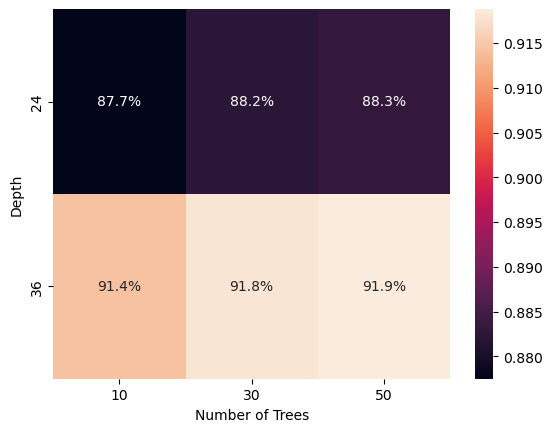

In [23]:
ax = sns.heatmap(accuracies_rect,annot=True,fmt=".1%")
ax.set_ylabel("Depth");
ax.set_yticklabels(depths)
ax.set_xlabel("Number of Trees");
ax.set_xticklabels(n_estimators);

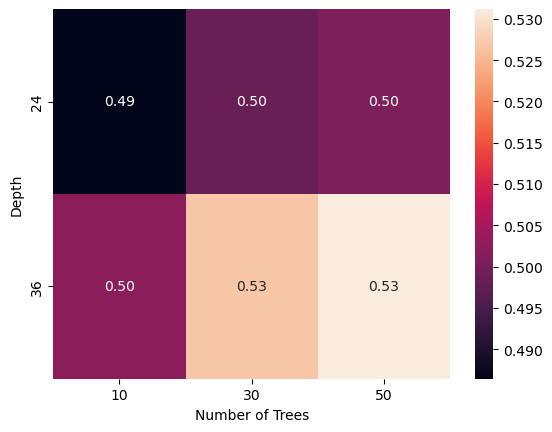

In [26]:
ax = sns.heatmap(MCCs_rect,annot=True,fmt=".2f")
ax.set_ylabel("Depth");
ax.set_yticklabels(depths)
ax.set_xlabel("Number of Trees");
ax.set_xticklabels(n_estimators);

The optimal model is just using the maximum depth and number of estimators, although the difference between 30 and 50 trees is small.
One could likely get even better scores by going to even deeper trees.

Finally, let us train the 30 tree depth 36 model on the combined training and validation set and evaluate it on test set, to predict its performance.

In [2]:
data_train = pd.read_parquet(path_train, engine="pyarrow")
data_val = pd.read_parquet(path_val, engine="pyarrow")
data_combined = pd.concat([data_train, data_val], ignore_index=True)
data_combined.to_parquet(path_trainval, index=False, engine="pyarrow")

In [2]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours
clf = RandomForestClassifier(n_estimators=30, max_depth=36, n_jobs=-1, class_weight="balanced")
print("Training: ")
clf,feature_names = train(path_trainval, clf, features, preprocess=pre)
print("Test:")
validate(clf, path_test, features, preprocess=pre);

Training: 
Accuracy: 0.9927584702169808
Confusion: 
[[0.99393407 0.00606593]
 [0.01680724 0.98319276]]
MCC: 0.9635310286481322
Test:
Accuracy: 0.9187787435147422
Confusion: 
[[0.97189884 0.02810116]
 [0.51283965 0.48716035]]
MCC: 0.5334492144795058


Let us also consider the Tree which performed best on Customers, in case that this is more important.

In [3]:
features = ["tripduration", "summer","business day", "haversine distance", "is_roundtrip", "speed", "start station id", "end station id"]
pre = add_hours
clf = DecisionTreeClassifier(max_depth=24, class_weight="balanced")
print("Training: ")
clf,feature_names = train(path_trainval, clf, features, preprocess=pre)
print("Validation:")
validate(clf, path_test, features, preprocess=pre);

Training: 
Accuracy: 0.8724555977659597
Confusion: 
[[0.8669855  0.1330145 ]
 [0.08303491 0.91696509]]
MCC: 0.5919761062738494
Validation:
Accuracy: 0.8288092182908153
Confusion: 
[[0.84236287 0.15763713]
 [0.28131868 0.71868132]]
MCC: 0.42367844082179973
